In [1]:
%matplotlib widget
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, TextBox
from torchvision import models, transforms
from PIL import Image

# ==== Model ====
class SteeringClassifier(nn.Module):
    def __init__(self, num_classes=15):
        super(SteeringClassifier, self).__init__()
        resnet = models.resnet18(pretrained=True)
        resnet.fc = nn.Identity()
        self.cnn = resnet
        self.turn_embed = nn.Embedding(3, 16)  # turn signals: -1, 0, 1 → 0, 1, 2
        self.fc = nn.Sequential(
            nn.Linear(512 + 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, image, turn_signal):
        x_img = self.cnn(image)
        x_signal = self.turn_embed(turn_signal)
        x = torch.cat((x_img, x_signal), dim=1)
        return self.fc(x)

# ==== Prediction Logic ====
CLASS_NAMES = [
    "Left Hardest", "Left Harder", "Left Hard", "Left Medium", "Left Light", "Left Slight", "Left Minimal",
    "No Turning",
    "Right Minimal", "Right Slight", "Right Light", "Right Medium", "Right Hard", "Right Harder", "Right Hardest"
]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def predict(model, image, turn_signal, device='cuda'):
    model.eval()
    model.to(device)

    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    img_tensor = transform(image).unsqueeze(0).to(device)
    turn_tensor = torch.tensor([[turn_signal + 1]], dtype=torch.long).to(device)

    with torch.no_grad():
        output = model(img_tensor, turn_tensor.squeeze(1))
        pred_class = output.argmax(dim=1).item()

    return CLASS_NAMES[pred_class]

# ==== Load model ====
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SteeringClassifier()
model.load_state_dict(torch.load("../Models/steering_model_final.pth", map_location=device))
model.eval()

# ==== Load data ====
images = np.load("../output/std_images.npy")         # shape: (N, 3, 244, 244) or (N, H, W, 3)
angles = np.load("../output/std_angles.npy")         # shape: (N,)
turn_signals = np.load("../output/std_turn_signals.npy")  # values: -1, 0, 1

# Convert image shape if needed
if images.ndim == 4 and images.shape[1] == 3:
    images = np.transpose(images, (0, 2, 3, 1))  # (N, H, W, 3)

if images.max() <= 1.0:
    images = (images * 255).astype(np.uint8)

# ==== Viewer ====
index = [0]
skip_step = 10

fig, ax = plt.subplots(figsize=(6, 4))
plt.subplots_adjust(bottom=0.3)

def show_image(idx):
    ax.clear()
    img = images[idx]
    steering = angles[idx]
    turn = int(turn_signals[idx])
    turn_label = "Left" if turn == -1 else "Right" if turn == 1 else "None"
    pred_label = predict(model, img, turn, device)

    ax.imshow(img)
    ax.set_title(f"Index: {idx} | Steering: {steering:.2f} | Signal: {turn_label} | 🚘 Pred: {pred_label}")
    ax.axis('off')
    plt.draw()

def next_image(event):
    index[0] = (index[0] + 1) % len(images)
    show_image(index[0])

def prev_image(event):
    index[0] = (index[0] - 1) % len(images)
    show_image(index[0])

def skip_forward(event):
    index[0] = (index[0] + skip_step) % len(images)
    show_image(index[0])

def skip_back(event):
    index[0] = (index[0] - skip_step) % len(images)
    show_image(index[0])

def goto_index(text):
    try:
        i = int(text)
        index[0] = i % len(images)
        show_image(index[0])
    except ValueError:
        pass

# ==== Buttons ====
axprev = plt.axes([0.05, 0.15, 0.1, 0.075])
axnext = plt.axes([0.17, 0.15, 0.1, 0.075])
axskipb = plt.axes([0.29, 0.15, 0.1, 0.075])
axskipf = plt.axes([0.41, 0.15, 0.1, 0.075])

btn_prev  = Button(axprev,  'Prev')
btn_next  = Button(axnext,  'Next')
btn_skipb = Button(axskipb, f'-{skip_step}')
btn_skipf = Button(axskipf, f'+{skip_step}')

btn_prev.on_clicked(prev_image)
btn_next.on_clicked(next_image)
btn_skipb.on_clicked(skip_back)
btn_skipf.on_clicked(skip_forward)

axtbox = plt.axes([0.60, 0.15, 0.2, 0.075])
text_box = TextBox(axtbox, 'Go to idx', initial=str(index[0]))
text_box.on_submit(goto_index)



RuntimeError: 'widget' is not a recognised GUI loop or backend name

c:\Users\deyru\anaconda3\envs\ACS\lib\site-packages\ipympl\backend_nbagg.py:335: UserWarning: Glyph 128664 (\N{ONCOMING AUTOMOBILE}) missing from font(s) DejaVu Sans.
  self.figure.savefig(buf, format='png', dpi='figure')


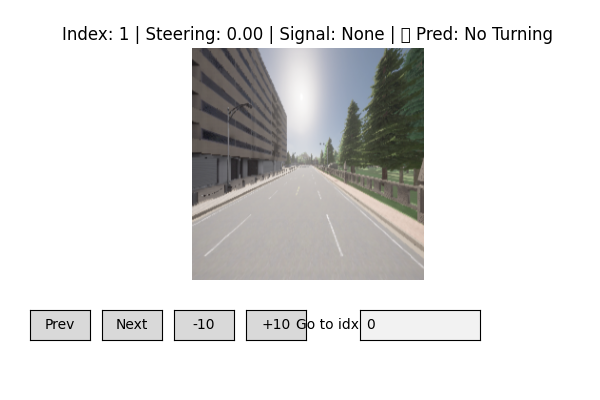

In [ ]:
# ==== Start viewer ====
show_image(index[0])
plt.show()
